In [268]:
from ase import * 
from pylab import *
from ase.build import nanotube
from ase.build import graphene_nanoribbon
import plotly.graph_objects as go
from numpy import linalg as LA
from scipy.linalg import ishermitian

In [269]:
KL1 = 365.0 #N/m
KT1 = 245.0 #N/m
KZ1 = 98.2 #N/m

# En esta descripción, la componente fuera del plano apunta
# a lo largo del eje x, la descripción del enlace más
# fuerte apunta a lo largo del eje y, y la componente
# tangencial apunta a lo largo del eje z.
Kbase = array([[KZ1,0,0],
            [0,KL1,0],
            [0,0,KT1]],dtype=complex)

In [270]:
cnt1 = nanotube(4,2, length = 1)

In [271]:
X,Y,Z    = cnt1.get_positions().T
r = cnt1.get_positions()
nsites   = len(X)
a1,a2,a3 = array(cnt1.get_cell())

cluz = 3e10 #cm
masas = cnt1.get_masses()
masas = 1.66e-27*masas

print(f"nsites = {nsites}")
print(f"    a1 = {a1}")
print(f"    a2 = {a2}")
print(f"    a3 = {a3}")

nsites = 56
    a1 = [0. 0. 0.]
    a2 = [0. 0. 0.]
    a3 = [ 0.          0.         11.27090059]


In [272]:
def findnn(X,Y,Z):
  nn = {}
  for todos in range(len(X)):

      UnSitio     = array([X[todos],Y[todos],Z[todos]])
      DataUnSitio = kron(ones(nsites),UnSitio)
      DataUnSitio = DataUnSitio.reshape(nsites,3)

      Dif = DataUnSitio - array([X,Y,Z]).T
      normas = []
      for n in range(len(Dif)):
          norm = sqrt(dot(Dif[n],Dif[n]))
          normas.append(norm)
      normas  = array(normas)
      logical = normas<1.44 # distancia en Ang para encontrar los vecinos

      nn[todos] = delete( logical.nonzero()[0], \
          where(logical.nonzero()[0] == todos) )
  return nn

def findnn_minus(X,Y,Z):
  nn_minus_a3 = {}
  for todos in range(len(X)):

      UnSitio     = array([X[todos]+a3[0],Y[todos]+a3[1],Z[todos]+a3[2]])
      DataUnSitio = kron(ones(nsites),UnSitio)
      DataUnSitio = DataUnSitio.reshape(nsites,3)

      Dif = DataUnSitio - array([X,Y,Z]).T
      normas = []
      for n in range(len(Dif)):
          norm = sqrt(dot(Dif[n],Dif[n]))
          normas.append(norm)
      normas  = array(normas)
      logical = normas<1.44 # distancia en Ang para encontrar los vecinos

      nn_minus_a3[todos] = delete( logical.nonzero()[0], \
          where(logical.nonzero()[0] == todos) )
  return nn_minus_a3

def findnn_plus(X,Y,Z):
  nn_plus_a3 = {}
  for todos in range(len(X)):

      UnSitio     = array([X[todos]-a3[0],Y[todos]-a3[1],Z[todos]-a3[2]])
      DataUnSitio = kron(ones(nsites),UnSitio)
      DataUnSitio = DataUnSitio.reshape(nsites,3)

      Dif = DataUnSitio - array([X,Y,Z]).T
      normas = []
      for n in range(len(Dif)):
          norm = sqrt(dot(Dif[n],Dif[n]))
          normas.append(norm)
      normas  = array(normas)
      logical = normas<1.44 # distancia en Ang para encontrar los vecinos

      nn_plus_a3[todos] = delete( logical.nonzero()[0], \
          where(logical.nonzero()[0] == todos) )
  return nn_plus_a3

def GetDATAplot(X,Y,Z,nn,nn_minus_a3,nn_plus_a3):
  DATA = [go.Scatter3d(x=X, y=Y, z=Z,mode='markers',showlegend=False)]

  for key in nn: # para cada sitio
      for n in nn[key]: # para cada vecino
          DATA.append( go.Scatter3d(x=[X[key],X[n]], y=[Y[key],Y[n]], z=[Z[key],Z[n]],mode='lines',line=dict(color='blue'),showlegend=False))

  for key in nn_minus_a3: # para cada sitio
      for n in nn_minus_a3[key]: # para cada vecino
          DATA.append( go.Scatter3d(x=[X[key]+a3[0],X[n]], y=[Y[key]+a3[1],Y[n]], z=[Z[key]+a3[2],Z[n]],mode='lines',line=dict(color='red'),showlegend=False) )

  for key in nn_plus_a3: # para cada sitio
      for n in nn_plus_a3[key]: # para cada vecino
          DATA.append( go.Scatter3d(x=[X[key]-a3[0],X[n]], y=[Y[key]-a3[1],Y[n]], z=[Z[key]-a3[2],Z[n]],mode='lines',line=dict(color='red'),showlegend=False) )

  annos = []
  # for n in range(len(X)):
  for n in range(len(X)):
    anno = dict(x=X[n],
                y=Y[n],
                z=Z[n],
                text=str(n),
                showarrow=False,
                arrowhead=0,
                font=dict(color='black'),
                ax=0,
                ay=0,
                bgcolor="white",
                opacity=0.2)

    annos.append(anno)

  return DATA,annos

In [273]:
nn = findnn(X,Y,Z)
nn_minus_a3= findnn_minus(X,Y,Z)
nn_plus_a3  = findnn_plus(X,Y,Z)

In [274]:
DATA,annos = GetDATAplot(X,Y,Z,nn,nn_minus_a3,nn_plus_a3)
fig = go.Figure(data=DATA)
fig.update_layout(scene=dict(annotations=annos))
# fig.add_annotation(x=X[0], y=Y[0],text="0",showarrow=False,yshift=10)
fig.show()

In [275]:
# Se definen algunas rotaciones útiles

# Rotación respecto al eje z.
def U(θ):
    U = array([[cos(θ),-sin(θ),0],
              [sin(θ),cos(θ),0],
              [       0,      0,1]],dtype = complex)
    return U

# Rotación respecto al ele x. Esta rotación se usa
# para elevar el enlace principal un ángulo φ respecto
# al plano xy.

def T(φ):
    T = array([[1   ,0.      ,0],
                [0. ,cos(φ) ,-1*sin(φ)],
                [0  ,sin(φ)  ,cos(φ)]],dtype = complex)
    return T

# Función que aplica una transformación O a un operador A.
def TensTransform(A,O):
    return dot(O,dot(A,inv(O)))


In [276]:
def KGeneral(r1,r2):

  x1,y1,z1 = r1[0],r1[1],r1[2]
  x2,y2,z2 = r2[0],r2[1],r2[2]

  x12 = x2 - x1
  y12 = y2 - y1
  z12 = z2 - z1

  rij = array([x12,y12,z12])

  # Se obtiene el ángulo del enlace con el plano xy.
  
  φ = arcsin(dot(rij,[0,0,1])/LA.norm(rij))

  # Se obtiene el ángulo del enlace con el eje y.

  if x12**2 + y12**2 != 0:
    θ = sign(y12)*arccos(y12/sqrt(x12**2 + y12**2))
  else:
    θ = 0

  Krotplano = TensTransform(Kbase,T(φ))
  Kfinal = TensTransform(Krotplano,U(θ))
  
  return Kfinal


In [277]:
def OperadorPseudomomento(n):

  Sz = array([[0,-1J,0],
              [1J,0,0],
              [0,0,0]],dtype=complex)

  return np.kron(np.eye(n,dtype=complex),Sz)

def expectedval(vec,S):
    return dot(np.conj(vec).T,dot(S,vec)).real

S = OperadorPseudomomento(nsites)

In [278]:
def Eigenfrequencies(kvec):
  MatrizDinamica = {}
  MatInt = array(range(nsites*nsites)).reshape(nsites,nsites)

  for i in range(len(X)):

    #print("Esta es la iteración de i =",str(i))

    ri = [X[i],Y[i],Z[i]]

    Kdiagi = np.zeros((3,3))

    for n in nn[i]:
      #print("Vecino cercano de átomo",str(i),"número",str(n))
      rn = [X[n],Y[n],Z[n]]
      Kdiagi = Kdiagi + KGeneral(ri,rn)
    for n in nn_plus_a3[i]:
      #print("Vecino cercano plus de átomo",str(i),"número",str(n))
      rn = [X[n],Y[n],Z[n]] + a3
      Kdiagi = Kdiagi + KGeneral(ri,rn)
    for n in nn_minus_a3[i]:
      #print("Vecino cercano minus de átomo",str(i),"número",str(n))
      rn = [X[n],Y[n],Z[n]] - a3
      Kdiagi = Kdiagi + KGeneral(ri,rn)


    """for n in np.concatenate((nn[i], nn_plus_a3[i],nn_minus_a3[i])):
      rn = [X[n],Y[n],Z[n]] + a3
      Kdiagi = Kdiagi + KGeneral(Kx,ri,rn)"""

    MatrizDinamica[(nsites)*i + i] = Kdiagi/masas[i]

    for j in range(i+1,len(X)):
      rj = [X[j],Y[j],Z[j]]
      if j in nn[i]:
        K = -1*KGeneral(ri,rj)/sqrt(masas[i]*masas[j])
        #print("Elemento fuera de la diagonal de primer vecino asociado a átomos",str(i),str(j))
        MatrizDinamica[(nsites)*i + j] = -1*KGeneral(ri,rj)/sqrt(masas[i]*masas[j])
        MatrizDinamica[(nsites)*j + i] = K.T
      elif j in nn_plus_a3[i]:
        K = -1*KGeneral(ri,rj + a3)/sqrt(masas[i]*masas[j])
        #print("Elemento fuera de la diagonal de primer vecino plus asociado a átomos",str(i),str(j))
        MatrizDinamica[(nsites)*i + j] = K*exp(1J*kvec)
        MatrizDinamica[(nsites)*j + i] = K*exp(-1J*kvec)
        #MatrizDinamica[(nsites)*j + i] = (-1*KGeneral(ri,rj + a3)/sqrt(masas[i]*masas[j])*exp(-1J*kvec))
      elif j in nn_minus_a3[i]:
        K = -1*KGeneral(ri,rj - a3)/sqrt(masas[i]*masas[j])
        #print("Elemento fuera de la diagonal de primer vecino minus asociado a átomos",str(i),str(j))
        MatrizDinamica[(nsites)*i + j] = K*exp(-1J*kvec)
        #MatrizDinamica[(nsites)*j + i] = (-1*KGeneral(ri,rj - a3)/sqrt(masas[i]*masas[j])*exp(1J*kvec))
        MatrizDinamica[(nsites)*j + i] = K*exp(1J*kvec)
      else:
          MatrizDinamica[(nsites)*i + j] = np.zeros((3,3))
          MatrizDinamica[(nsites)*j + i] = np.zeros((3,3))

    """for j in range(i):
      MatrizDinamica[(nsites)*i + j] = np.zeros((3,3))"""

  MatrizDinamica = dict(sorted(MatrizDinamica.items()))

  Dm = [ [MatrizDinamica[i] for i in rw] for rw in MatInt ]
  Dynamical = asarray(np.bmat(Dm))

  ω2,eigvecs = eigh(Dynamical)

  pseudomom = []


  for i in range(len(ω2)):
    eigvec = eigvecs[:,i]
    pseudomom.append(expectedval(eigvec,S))


  return sqrt(abs(ω2))/2/pi/cluz,pseudomom

In [279]:
def Eigenfrequencies(kvec):
  MatrizDinamica = {}
  MatInt = array(range(nsites*nsites)).reshape(nsites,nsites)

  for i in range(len(X)):

    #print("Esta es la iteración de i =",str(i))

    ri = [X[i],Y[i],Z[i]]

    Kdiagi = np.zeros((3,3))

    for n in nn[i]:
      #print("Vecino cercano de átomo",str(i),"número",str(n))
      rn = [X[n],Y[n],Z[n]]
      Kdiagi = Kdiagi + KGeneral(ri,rn)
    for n in nn_plus_a3[i]:
      #print("Vecino cercano plus de átomo",str(i),"número",str(n))
      rn = [X[n],Y[n],Z[n]] + a3
      Kdiagi = Kdiagi + KGeneral(ri,rn)
    for n in nn_minus_a3[i]:
      #print("Vecino cercano minus de átomo",str(i),"número",str(n))
      rn = [X[n],Y[n],Z[n]] - a3
      Kdiagi = Kdiagi + KGeneral(ri,rn)



    """for n in np.concatenate((nn[i], nn_plus_a3[i],nn_minus_a3[i])):
      rn = [X[n],Y[n],Z[n]] + a3
      Kdiagi = Kdiagi + KGeneral(Kx,ri,rn)"""

    MatrizDinamica[(nsites)*i + i] = Kdiagi/masas[i]

    for j in range(i+1,len(X)):
      rj = [X[j],Y[j],Z[j]]
      if j in nn[i]:
        K = -1*KGeneral(ri,rj)/sqrt(masas[i]*masas[j])
        #print("Elemento fuera de la diagonal de primer vecino asociado a átomos",str(i),str(j))
        MatrizDinamica[(nsites)*i + j] = -1*KGeneral(ri,rj)/sqrt(masas[i]*masas[j])
        MatrizDinamica[(nsites)*j + i] = K.T
      elif j in nn_plus_a3[i]:
        K = -1*KGeneral(ri,rj + a3)/sqrt(masas[i]*masas[j])
        #print("Elemento fuera de la diagonal de primer vecino plus asociado a átomos",str(i),str(j))
        MatrizDinamica[(nsites)*i + j] = K*exp(1J*kvec)
        MatrizDinamica[(nsites)*j + i] = K*exp(-1J*kvec)
        #MatrizDinamica[(nsites)*j + i] = (-1*KGeneral(ri,rj + a3)/sqrt(masas[i]*masas[j])*exp(-1J*kvec))
      elif j in nn_minus_a3[i]:
        K = -1*KGeneral(ri,rj - a3)/sqrt(masas[i]*masas[j])
        #print("Elemento fuera de la diagonal de primer vecino minus asociado a átomos",str(i),str(j))
        MatrizDinamica[(nsites)*i + j] = K*exp(-1J*kvec)
        #MatrizDinamica[(nsites)*j + i] = (-1*KGeneral(ri,rj - a3)/sqrt(masas[i]*masas[j])*exp(1J*kvec))
        MatrizDinamica[(nsites)*j + i] = K*exp(1J*kvec)
      else:
          MatrizDinamica[(nsites)*i + j] = np.zeros((3,3))
          MatrizDinamica[(nsites)*j + i] = np.zeros((3,3))

    """for j in range(i):
      MatrizDinamica[(nsites)*i + j] = np.zeros((3,3))"""
    

  MatrizDinamica = dict(sorted(MatrizDinamica.items()))

  Dm = [ [MatrizDinamica[i] for i in rw] for rw in MatInt ]
  Dynamical = asarray(np.bmat(Dm))

  ω2,eigvecs = eigh(Dynamical)

  pseudomom = []

  for i in range(len(ω2)):
    eigvec = eigvecs[:,i]
    pseudomom.append(expectedval(eigvec,S))


  return sqrt(abs(ω2))/2/pi/cluz,pseudomom

In [280]:
Kpoints = np.linspace(-pi/a3[2],pi/a3[2],100)

Klabels = [r"K/2",r"Γ",r"K/2"]
Kticks = concatenate([[0],[50],[100]])

Bandas = []
Pseudomom = []

Kevaluate = (list( map(Eigenfrequencies,Kpoints) ))

for ω2,psmom in Kevaluate:
  Bandas.append(ω2)
  Pseudomom.append(psmom)

Bandas = array(Bandas)
Pseudomom = array(Pseudomom)

numK,nbands = shape(Bandas)
kenum = arange(numK)

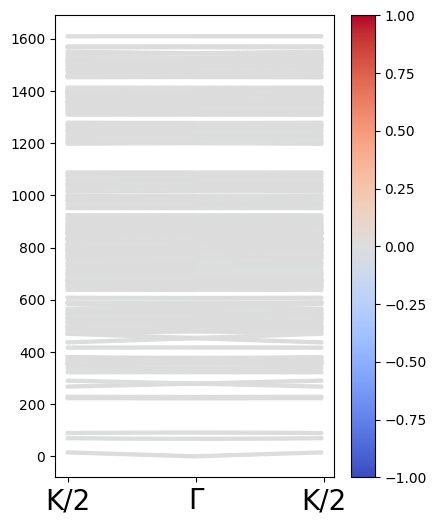

In [284]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4.5,6))
for j in range(nbands):
  grafica = ax.scatter(kenum,Bandas.T[j],c = Pseudomom.T[j],cmap = "coolwarm",vmax = 1, vmin = -1,s = 5)
fig.colorbar(grafica)
ax.set_xticks(Kticks)
ax.set_xticklabels(Klabels,fontsize = 20);

In [283]:
Eigenfrequencies(0)

(array([9.10094424e+01, 1.60661994e-05, 6.71824704e+01, 2.22259508e+02,
        2.27553727e+02, 2.78380539e+02, 2.78923080e+02, 3.22230358e+02,
        3.38566628e+02, 3.55110745e+02, 3.59081134e+02, 3.62470309e+02,
        3.63297432e+02, 3.64936744e+02, 3.66422501e+02, 3.68756123e+02,
        3.77448479e+02, 4.17047611e+02, 4.51651774e+02, 4.54236950e+02,
        4.78253613e+02, 4.80089550e+02, 4.85995787e+02, 4.87569612e+02,
        4.88967291e+02, 4.94051216e+02, 5.01662817e+02, 5.12421155e+02,
        5.18367612e+02, 5.25849825e+02, 5.28470308e+02, 5.30642317e+02,
        5.41105611e+02, 5.44691786e+02, 5.48904245e+02, 5.54027230e+02,
        5.69227302e+02, 5.71401408e+02, 5.75835203e+02, 5.79376349e+02,
        5.89465874e+02, 6.06822428e+02, 6.38026433e+02, 6.46647928e+02,
        6.52454451e+02, 6.54712376e+02, 6.60641227e+02, 6.68737127e+02,
        6.70109706e+02, 6.72296274e+02, 6.74673754e+02, 6.77340611e+02,
        6.79870880e+02, 6.91381184e+02, 6.98121708e+02, 7.019652